In [41]:
import os
import pandas as pd
from collections import Counter
import re
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', None)

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

In [42]:
bg_file = "/home2/s439906/project/CASP16/oligomer/3_stoichiometry/stoich_bg_distribution.csv"


In [43]:
# 读取 CSV 文件
data = pd.read_csv(bg_file)

# 提取和统计整数信息，并将不同字母前缀的整数视为等价
molecule_counts = Counter()
for _, row in data.iterrows():
    entry = row['stoichiometry']
    count = row['count']
    molecules = entry.split(", ")
    for molecule in molecules:
        # 仅提取整数部分并统计（如 A1 和 C1 视为等价，按 count 列的值累加）
        match = re.search(r'\d+', molecule)
        if match:
            molecule_counts[int(match.group())] += count

# 转换为 DataFrame 并显示结果
molecule_counts_df = pd.DataFrame(molecule_counts.items(), columns=['Integer', 'Count'])
print("整数信息统计（不同字母前缀的整数视为等价，按 count 列的值累加）：")
# print(molecule_counts_df)




整数信息统计（不同字母前缀的整数视为等价，按 count 列的值累加）：


In [44]:
import pandas as pd
from collections import Counter
import re
from itertools import combinations

# 读取 CSV 文件
data = pd.read_csv(bg_file)

# 提取和统计所有pairwise的整数信息
pairwise_counts = Counter()
for _, row in data.iterrows():
    entry = row['stoichiometry']
    count = row['count']
    molecules = entry.split(", ")
    # 提取整数部分
    integers = [re.search(r'\d+', molecule).group() for molecule in molecules if re.search(r'\d+', molecule)]
    if 1 < len(integers) <= 10:
        for pair in combinations(sorted(integers, reverse=True), 2):
            pairwise_counts[pair] += count

# 转换为 DataFrame 并显示结果
pairwise_counts_df = pd.DataFrame(pairwise_counts.items(), columns=['Pair', 'Count'])
print("Pairwise 整数信息统计：")
print(pairwise_counts_df)


Pairwise 整数信息统计：
          Pair   Count
0       (1, 1)  141813
1       (2, 2)   35604
2       (2, 1)   29521
3       (3, 3)   10627
4       (4, 4)    3027
..         ...     ...
667   (60, 15)       2
668   (60, 10)       4
669  (60, 480)       2
670   (45, 10)       1
671   (22, 12)       1

[672 rows x 2 columns]


In [45]:
import pandas as pd
from collections import Counter
import re
from itertools import combinations
from math import gcd

# 读取 CSV 文件
data = pd.read_csv(bg_file)

# 提取和统计所有pairwise的整数信息
pairwise_counts = Counter()
for _, row in data.iterrows():
    entry = row['stoichiometry']
    count = row['count']
    molecules = entry.split(", ")
    # 提取整数部分
    integers = [re.search(r'\d+', molecule).group() for molecule in molecules if re.search(r'\d+', molecule)]
    if 1 < len(integers) <= 10:
        for pair in combinations(sorted(integers, reverse=True), 2):
            pairwise_counts[pair] += count

# 转换为 DataFrame
pairwise_counts_df = pd.DataFrame(pairwise_counts.items(), columns=['Pair', 'Count'])

# 处理比例，将等价的组合合并，只在互质情况下保留原值
normalized_pairwise_counts = Counter()
for (a, b), count in pairwise_counts.items():
    a, b = int(a), int(b)
    common_divisor = gcd(a, b)
    if common_divisor > 1:
        normalized_pair = tuple(sorted((a // common_divisor, b // common_divisor), reverse=True))
    else:
        normalized_pair = tuple(sorted((a, b), reverse=True))
    normalized_pairwise_counts[normalized_pair] += count

# 转换为 DataFrame 并显示结果
normalized_pairwise_counts_df = pd.DataFrame(normalized_pairwise_counts.items(), columns=['Pair', 'Count'])
print("Normalized Pairwise 整数信息统计：")
print(normalized_pairwise_counts_df)


Normalized Pairwise 整数信息统计：
         Pair   Count
0      (1, 1)  200784
1      (2, 1)   37117
2      (4, 1)    4476
3      (3, 1)    7237
4      (3, 2)    2220
..        ...     ...
306   (17, 6)       1
307  (30, 17)       1
308  (30, 11)       1
309  (17, 11)       1
310   (25, 6)       3

[311 rows x 2 columns]


In [46]:
total_count_pair = sum(normalized_pairwise_counts_df['Count'])
normalized_pairwise_counts_df['Count'] /= total_count_pair
normalized_pairwise_counts_df.set_index('Pair', inplace=True)
# convert every element in index to string
normalized_pairwise_counts_df.index = normalized_pairwise_counts_df.index.map(lambda x: tuple(map(str, x)))
normalized_pairwise_counts_df

Count
Pair Pair          
1    1     0.756608
2    1     0.139867
4    1     0.016867
3    1     0.027271
     2     0.008366
...             ...
17   6     0.000004
30   17    0.000004
     11    0.000004
17   11    0.000004
25   6     0.000011

[311 rows x 1 columns]

In [47]:
total_count_molecule = sum(molecule_counts_df['Count'])
molecule_counts_df['Count'] /= total_count_molecule
# set Integer as index
molecule_counts_df.set_index('Integer', inplace=True)
molecule_counts_df.index = molecule_counts_df.index.map(str)
molecule_counts_df

,Count
Integer,
1,0.698340
2,0.191822
4,0.033399
3,0.031294
6,0.013806
...,...
535,0.000004
530,0.000004
346,0.000001


In [48]:
stoichiometry_dir = "/data/data1/conglab/jzhan6/CASP16/CASP16_scores/oligo_20240910/firstmodels/"
stoichiometry_files = [file for file in os.listdir(stoichiometry_dir) if file.endswith('.stoichiometry')]
# sort files alphabetically
stoichiometry_files.sort()
stoichiometry_files.__len__()

28

In [49]:
for file in stoichiometry_files:
    file = os.path.join(stoichiometry_dir, file)
    data = pd.read_csv(file, sep='\t')
    data['group_info'] = data['model'].str.extract(r'(TS\d{3})')
data

,model,stoi,truth,match_status,group_info
0,T0270TS423_1o,A6,A6,yes,TS423
1,T0270TS298_1o,A6,A6,yes,TS298
2,T0270TS015_1o,A6,A6,yes,TS015
3,T0270TS163_1o,A6,A6,yes,TS163
4,T0270TS191_1o,A6,A6,yes,TS191
5,T0270TS284_1o,A3,A6,no,TS284
6,T0270TS075_1o,A3,A6,no,TS075
7,T0270TS475_1o,A3,A6,no,TS475
8,T0270TS301_1o,A3,A6,no,TS301
9,T0270TS164_1o,A6,A6,yes,TS164


In [50]:
def extract_single_and_pairwise_combinations(column):
    single_numbers = [int(n) for n in re.findall(r'\d+', column)]
    pairwise_combinations = []
    for a, b in combinations(single_numbers, 2):
        if a == 0 or b == 0:
            pairwise_combinations.append((max(a, b), 0))  
        else:
            common_divisor = gcd(a, b)
            reduced_pair = (a // common_divisor, b // common_divisor)
            pairwise_combinations.append((max(reduced_pair), min(reduced_pair)))
    return single_numbers, pairwise_combinations

def calculate_single_scores(single_list, probability_df):
    return [1 - probability_df.loc[str(n), 'Count'] if str(n) in probability_df.index else 0 for n in single_list]

def calculate_pairwise_scores(pairwise_list, probability_df):
    return [1 - probability_df.loc[tuple(sorted(map(str, pair), reverse=True)), 'Count'] if tuple(sorted(map(str, pair), reverse=True)) in probability_df.index else 0 for pair in pairwise_list]

def calculate_combined_single_score(stoi_single, truth_single, truth_single_scores):
    combined_score = 0
    for i, num in enumerate(truth_single):
        if num in stoi_single:
            combined_score += truth_single_scores[i]
    return combined_score

def calculate_combined_pairwise_score(stoi_pairwise, truth_pairwise, truth_pairwise_scores):
    combined_score = 0
    for i, pair in enumerate(truth_pairwise):
        if pair in stoi_pairwise:
            combined_score += truth_pairwise_scores[i]
    return combined_score


score_all = None
for file in stoichiometry_files:
    file_abs = os.path.join(stoichiometry_dir, file)
    data = pd.read_csv(file_abs, sep='\t')
    data['group_info'] = data['model'].str.extract(r'(TS\d{3})')
    data['stoi_single'] = data['stoi'].apply(lambda x: extract_single_and_pairwise_combinations(x)[0])
    data['stoi_pairwise'] = data['stoi'].apply(lambda x: extract_single_and_pairwise_combinations(x)[1])
    data['truth_single'] = data['truth'].apply(lambda x: extract_single_and_pairwise_combinations(x)[0])
    data['truth_pairwise'] = data['truth'].apply(lambda x: extract_single_and_pairwise_combinations(x)[1])
    data['truth_single_scores'] = data['truth_single'].apply(lambda x: calculate_single_scores(x, molecule_counts_df))
    data['truth_pairwise_scores'] = data['truth_pairwise'].apply(lambda x: calculate_pairwise_scores(x, normalized_pairwise_counts_df))
    data['score_single'] = data.apply(lambda row: calculate_combined_single_score(row['stoi_single'], row['truth_single'], row['truth_single_scores']), axis=1)
    data['score_pairwise'] = data.apply(lambda row: calculate_combined_pairwise_score(row['stoi_pairwise'], row['truth_pairwise'], row['truth_pairwise_scores']), axis=1)
    data['sum_score'] = data['score_single'] + data['score_pairwise']
    # print(data[['model', 'stoi', 'truth', 'stoi_single', 'stoi_pairwise', 'truth_single', 'truth_pairwise', 'truth_single_scores', 'truth_pairwise_scores', 'score_single', 'score_pairwise', 'sum_score']])
    # get group_info and sum_score, and change sum_score name to file.split('.')[-1]
    result = data[['group_info', 'sum_score']]
    result.columns = ['group_info', file.split('.')[0]]
    # set group_info as index
    result.set_index('group_info', inplace=True)
    print(result)
    if score_all is None:
        score_all = result
    else:
        # merge result to score_all
        score_all = pd.concat([score_all, result], axis=1)


               H0208
group_info          
TS419       0.846712
TS397       0.846712
TS075       0.846712
TS079       0.846712
TS059       0.846712
TS286       0.846712
TS267       0.846712
TS388       0.846712
TS400       0.846712
TS393       0.846712
TS264       0.846712
TS312       0.846712
TS221       0.846712
TS196       0.846712
TS380       0.846712
TS293       0.846712
TS456       0.846712
TS475       0.846712
TS301       0.846712
TS241       0.846712
TS304       0.846712
TS369       0.846712
TS219       0.846712
TS322       0.846712
TS191       0.846712
TS052       0.846712
TS319       0.846712
TS298       0.846712
TS375       0.846712
TS423       0.846712
TS022       0.846712
TS311       0.846712
TS284       0.846712
TS139       0.846712
TS148       0.846712
TS262       0.846712
TS208       0.846712
TS122       0.846712
TS261       0.846712
TS331       0.243392
TS051       0.243392
TS345       0.243392
TS494       0.243392
TS274       0.243392
TS163       0.243392
TS164       0

In [51]:
score_all
# sum and sort by sum
score_all['sum'] = score_all.sum(axis=1)
score_all.sort_values(by='sum', ascending=False, inplace=True)
score_all


,H0208,H0215,H0217,H0220,H0222,H0223,H0225,H0227,H0229,H0230,H0232,H0233,H0236,H0244,H0245,H0258,H0265,H0267,H0272,T0206o,T0218o,T0234o,T0235o,T0237o,T0240o,T0257o,T0259o,T0270o,sum
TS331,0.243392,0.846712,8.499952,2.251394,1.635156,1.635156,1.635156,2.275034,0.243392,0.243392,1.859748,3.154711,0.968706,3.154711,0.846712,1.969971,0.000000,0.243392,11.477062,0.808178,0.808178,0.968706,0.986194,0.966601,0.968706,0.968706,0.968706,0.986194,51.613922
TS425,0.243392,0.846712,8.499952,2.251394,1.635156,1.635156,1.635156,2.275034,0.243392,0.243392,1.859748,3.154711,0.968706,3.154711,0.846712,1.969971,0.000000,0.243392,11.477062,0.808178,0.808178,0.968706,0.986194,0.966601,0.968706,0.968706,0.968706,0.986194,51.613922
TS322,0.846712,0.846712,8.499952,2.251394,1.635156,1.635156,1.635156,2.275034,0.243392,0.243392,1.859748,3.154711,2.815034,0.730177,0.846712,1.969971,0.000000,0.243392,11.477062,0.808178,0.000000,0.968706,0.986194,0.966601,0.968706,0.968706,0.968706,0.000000,49.844664
TS051,0.243392,0.846712,8.499952,2.251394,1.635156,1.635156,1.635156,2.275034,0.243392,0.243392,1.859748,3.154711,0.968706,0.730177,0.846712,1.969971,0.000000,0.243392,11.477062,0.808178,0.808178,0.968706,0.986194,0.966601,0.968706,0.968706,0.968706,0.986194,49.189389
TS345,0.243392,0.846712,8.499952,2.251394,1.635156,1.635156,1.635156,2.275034,0.243392,0.243392,1.859748,3.154711,0.968706,0.730177,0.846712,1.969971,0.000000,0.243392,11.477062,0.808178,0.808178,0.968706,0.986194,0.966601,0.968706,0.968706,0.968706,0.000000,48.203195
TS148,0.846712,0.846712,8.499952,2.251394,1.635156,1.635156,1.635156,2.275034,0.243392,0.243392,1.859748,0.730177,2.815034,3.154711,0.846712,0.301660,0.000000,0.243392,11.477062,0.808178,NaN,0.968706,0.986194,0.966601,0.968706,0.968706,0.968706,0.000000,48.176352
TS264,0.846712,0.846712,8.499952,2.251394,1.635156,1.635156,1.635156,2.275034,0.243392,0.243392,1.859748,0.730177,2.815034,3.154711,0.846712,0.301660,0.000000,0.243392,11.477062,0.808178,NaN,0.968706,0.986194,0.966601,0.968706,0.968706,0.968706,0.000000,48.176352
TS312,0.846712,0.846712,8.499952,2.251394,1.635156,1.635156,1.635156,2.275034,0.243392,0.243392,1.859748,0.730177,2.815034,3.154711,0.846712,0.301660,0.000000,0.243392,11.477062,0.808178,NaN,0.968706,0.986194,0.966601,0.968706,0.968706,0.968706,0.000000,48.176352
TS022,0.846712,0.846712,8.499952,2.251394,1.635156,1.635156,1.635156,0.986194,0.243392,0.243392,1.859748,3.154711,0.968706,3.154711,0.846712,1.969971,0.000000,0.243392,11.477062,0.808178,0.000000,0.968706,0.000000,0.966601,0.968706,0.968706,0.968706,0.000000,48.147836
TS462,0.243392,0.846712,8.499952,2.251394,1.635156,1.635156,1.635156,2.275034,0.243392,0.243392,1.859748,3.154711,2.815034,0.730177,0.846712,0.808178,0.000000,0.243392,11.477062,0.808178,0.000000,0.968706,0.986194,0.966601,0.968706,0.968706,0.968706,0.000000,48.079551


In [52]:
normalized_pairwise_counts_df.loc[('2', '1'), 'Count']

0.13986675409045346

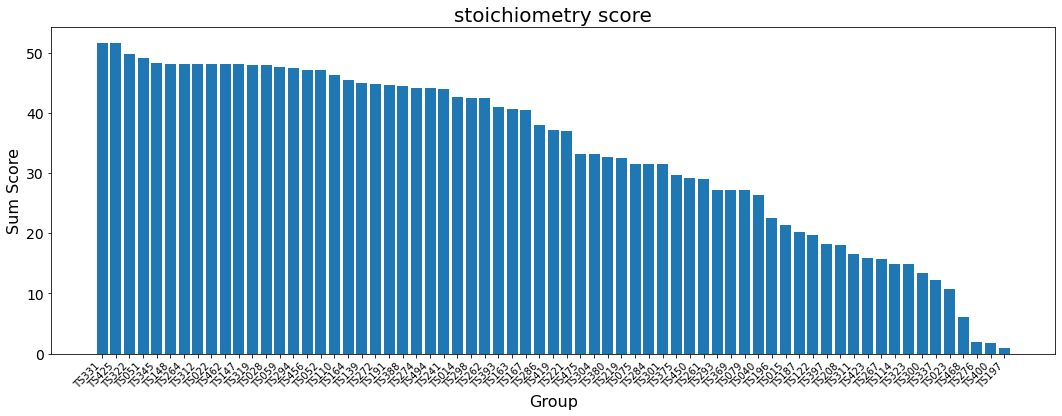

In [54]:
# plot  sum_score as bar plot
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 6))
plt.bar(score_all.index, score_all['sum'])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=14)
plt.xlabel('Group', fontsize=16)
plt.ylabel('Sum Score', fontsize=16)
plt.title('stoichiometry score', fontsize=20)
plt.show()
